# Let's discover our dataset files (assessment and EDA)
We have downloaded 5 files. As a reminder the short description, provided by insideairbnb, is:

| File name          | File description                                                                |
|--------------------|---------------------------------------------------------------------------------|
| calendar.csv.gz    | Detailed Calendar Data for listings in Paris                                    |
| reviews.csv.gz     | Detailed Review Data for listings in Paris                                      |
| listings.csv.gz    | Detailed Listings data for Paris                                                |
| listings.csv       | Summary information and metrics for listings in Paris (good for visualisations) |
| neighbourhoods.csv | Neighbourhood list for geo filter. Sourced from city or open source GIS files   |

In this notebook, we will load all files sequentially and perform **assessment** + short **Exploratory Data Analysis** phase for each of them.

Enough talking, let's load all files and display number of rows and columns for each one.

In [1]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../') 

from src.utils import datacollector
from src.utils import constants as cst
from src import visualization as viz
from src import cleaning

%matplotlib inline

#### Number of rows & columns for each file

In [6]:
file_list = datacollector.get_files_list()
for f in file_list:
    compression = 'gzip' if f.endswith(".gz") else 'infer'
    df = pd.read_csv(datacollector.get_data_file(f), sep=',', header=0, compression=compression)
    print("File {} has shape {}".format(f, df.shape))

File listings.csv.gz has shape (64293, 106)
File listings.csv has shape (64293, 16)
File calendar.csv.gz has shape (23467355, 7)
File reviews.csv.gz has shape (1205442, 6)
File neighbourhoods.csv has shape (20, 2)


***Observations:***
* Files `listings.csv` and `listings.csv.gz` are consistent in terms of rows, just the number of columns that changes. As per the files descriptions, the first one is a summary of the second, so this is expected.  
* `calendar` file is the one that contains the most important number of rows (23 million lines !)
* `reviews` file has also a lot of rows, more than one million, few columns.
* `neighbourhoods` file is very small with only 20 rows, which is not a big surprise as per file description.

---
# 1. Listings (summary) file
Let's start with the listings file, it is not the first one in the list but the name `listings` seems to be the key element for all other files as well (calendar and reviews are related to listing, as per the description).  
Moreover it is lighter than the complete one (16 columns instead of 106) and the description indicates that it is good for visualization.

In [2]:
df_lst_sum = pd.read_csv(datacollector.get_data_file(cst.LISTING_LIGHT_FILE), sep=',', header=0)
df_lst_sum.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,3109,zen and calm,3631,Anne,NaN,Observatoire,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
1,5396,Explore the heart of old Paris,7903,Borzou,NaN,Hôtel-de-Ville,48.85100,2.35869,Entire home/apt,115,1,180,2019-06-21,1.47,1,27
2,7397,MARAIS - 2ROOMS APT - 2/4 PEOPLE,2626,Franck,NaN,Hôtel-de-Ville,48.85758,2.35275,Entire home/apt,115,10,248,2019-06-25,2.47,1,240
3,7964,Large & sunny flat with balcony !,22155,Anaïs,NaN,Opéra,48.87464,2.34341,Entire home/apt,130,6,6,2015-09-14,0.05,1,302
4,8522,GREAT FLAT w/ CITY VIEW,25435,Adrien,NaN,Ménilmontant,48.86528,2.39326,Entire home/apt,90,3,1,2010-06-16,0.01,1,186


We have **16** features that describe what is a `listing` and give information about:
* who it belongs to (`host_id` and `host_name`)
* its `name` (some text probably written by the owner) and an `id` (numeric) (probably unique within the Information System)
* its location: some elements about `neighbourhood` (need to dig more this part later) and geographic coordinates `latitude` + `longitude`.
* its type (`room_type`). In this sample all values are the same so perhaps they come from a defined and finite list
* the `price` (numeric)
* `minimum number of nights` to stay I guess
* data about `reviews`: number of reviews for this listing, last time it has been reviewed and a statistic value
* `calculated_host_listings_count`: seems numeric but no real clue so far of what is means
* `availability_365`: I would guess that it means the number of days it is available in a whole year

I will not analyze too deeply this file as I guess that the one that I will really use will be the complete one so I will just perform some quick checks before moving on with another file.

#### Looking for NaN, column types

In [8]:
df_lst_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64293 entries, 0 to 64292
Data columns (total 16 columns):
id                                64293 non-null int64
name                              64224 non-null object
host_id                           64293 non-null int64
host_name                         64229 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     64293 non-null object
latitude                          64293 non-null float64
longitude                         64293 non-null float64
room_type                         64293 non-null object
price                             64293 non-null int64
minimum_nights                    64293 non-null int64
number_of_reviews                 64293 non-null int64
last_review                       49684 non-null object
reviews_per_month                 49684 non-null float64
calculated_host_listings_count    64293 non-null int64
availability_365                  64293 non-null int64
dt

***Observations:***  
There are few missing values in this dataset, only `neighbourhood_group` which has **only missing values** (so what is the purpose of providing this column ? Perhaps it makes sense for some other cities around the world but not for Paris).  
_Note for later: check in the complete file if it is the same and if yes then we can just drop the column_  
The other columns which contains missing values are the ones about `reviews` (23% missing).

#### Numeric values analysis

In [9]:
df_lst_sum.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,6.429300e+04,6.429300e+04,0.0,64293.000000,64293.000000,64293.000000,64293.000000,64293.000000,49684.000000,64293.000000,64293.000000
mean,1.934634e+07,6.648611e+07,NaN,48.864109,2.345350,116.763925,5.529342,18.749195,1.210193,7.814210,83.641314
std,1.116680e+07,7.693518e+07,NaN,0.018483,0.033776,164.316690,47.874056,38.751261,1.459079,35.337494,118.039870
min,3.109000e+03,2.419000e+03,NaN,48.812890,2.219430,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.186615e+06,1.080773e+07,NaN,48.850670,2.323950,60.000000,2.000000,1.000000,0.230000,1.000000,0.000000
50%,1.968928e+07,3.266216e+07,NaN,48.865260,2.348330,80.000000,2.000000,5.000000,0.700000,1.000000,15.000000
75%,2.950201e+07,9.359166e+07,NaN,48.879230,2.370900,120.000000,4.000000,19.000000,1.640000,1.000000,155.000000
max,3.656124e+07,2.748233e+08,NaN,48.905210,2.471890,9379.000000,9999.000000,809.000000,31.150000,323.000000,365.000000


***Observations:***  
The only relevant statistics to analyze are:
* `price`: **mean value is 116** (what is the currency ?) with an impressive max value (9379 !)
* `minimum_nights`: the **mean is around 5 days (so less than a week)** and 50% of the listing have a minimum at 2 so I would say that the "spirit" of the service is respected, we do not have to rent for one week minimum for instance.
* **each listing got around 18 `reviews` (mean)**, some of them have no review (min=0) which explains why we have seen missing values earlier and there is one listing that has more than 800 reviews !
* **At least 75% of the people have only one home/apartment to share** (probably the one in which they live for the most part of the year). But the max is high as well as the 'mean' and 'standard deviation' values so I guess that there is high variance in the last 25%. In the end, there is no reason for it to be different that everything else in the world: only few people, the richest, owns the most.
* some of the listing have no `availability` (min=0). Actually, it is even "worse" as **25% of them are not available !** (or maybe at the time the data have been collected it is booked and so not available anymore). 50% of them have few days (~2 weeks) of availability per year while some others are available full year. There is high variance in this feature (as per shown also by the standard deviation value). _Note for later:_ I will have to determine if the fact that listing is not available has an influence on other features, such as the price.

With this quick analysis, we can find some "intriguing" values:
* `minimum_nights`: the max is around _27 years_ ! What is this kind of listing ? Is it relevant to keep it in our analysis ?
* max value for the number of `reviews_per_month` for one listing is 31 which means that every day the listing got 1 review. How would that even be possible ? Are there several people who gave a review for the same listing on the same day ? Or is there any cheating here (i.e generating fake reviews) ?
* if my intuition about `calculated_host_listings_count` is right, that would mean that someone has 323 homes/apartments to rent in Paris. Wow, that's impressive, isn't it a business ?

#### Location (neighbourhood, (x,y) coordinates)
`Neighbourhood` seems to be categoric and nominal value, how many different values are there ? 

In [37]:
df_lst_sum.neighbourhood.nunique()

20

There are **20** different values for the neighbourhood. Not so much, later we can use dummy for 1-hot encoding if needed.  
Before going further, let's try to do something with the `latitude` and `longitude` values by plotting them with one different color per neighbourhood. Pay attention to the _palette_ choice as there are quite a lot to draw and if the choice is not appropriate, some colors are recycled which is quite hard to distinguish if they are used to near elements.

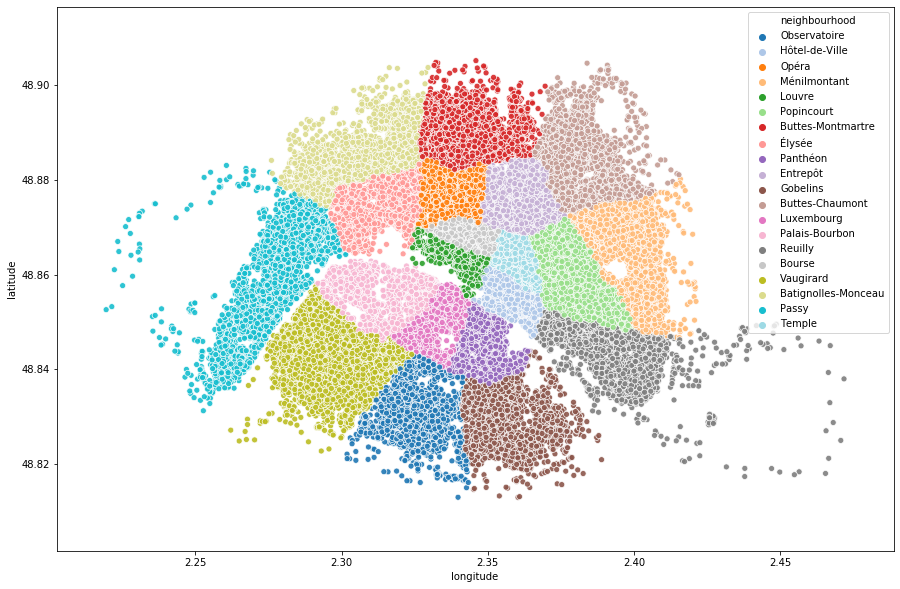

In [3]:
figure, axis = plt.subplots(1, 1, figsize=(15, 10))
sns.scatterplot(x="longitude", y="latitude", hue="neighbourhood", data=df_lst_sum, alpha=0.9, palette="tab20", ax=axis)
plt.show()

Okay ! Here are the 20 neighbourhoods in Paris, they correspond to the 20 districts the city has been splitted in.  
For those who do not know it, _"The twenty arrondissements are arranged in the form of a clockwise spiral (often likened to a snail shell),starting from the middle of the city, with the first on the Right Bank (north bank) of the Seine."([source](https://en.wikipedia.org/wiki/Arrondissements_of_Paris#Description))_  

Here is a picture so that you can compare the plot with the reality:
<img src="../assets/paris_neighbourhoods.png" width="550">  
Credits: Pline [CC BY-SA 3.0](http://creativecommons.org/licenses/by-sa/3.0/)  
We can clearly see why there are no listing in some places in neighbourhoods 12 or 16 (respectively 'Reuilly' and 'Passy'), it is because there are some woods ('Vincennes', 'Boulogne') !  
We are also able to guess the _'Seine'_ which is the river that crosses the city.

---
# 2. Calendar file
Next file to analyze is the one named `calendar`.

In [96]:
df_cal = pd.read_csv(datacollector.get_data_file(cst.CALENDAR_FILE), sep=',', header=0)
df_cal.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3109,2019-07-10,f,$75.00,$75.00,3.0,15.0
1,3109,2019-07-11,f,$75.00,$75.00,3.0,15.0
2,3109,2019-07-12,f,$75.00,$75.00,3.0,15.0
3,3109,2019-07-13,f,$75.00,$75.00,3.0,15.0
4,3109,2019-07-14,f,$75.00,$75.00,3.0,15.0


We have **7** features to describe what is a `calendar`:
* `listing_id`: seems to be a reference to listings we have previously seen so I guess we could **merge those 2 datasets on this id key**.
* `date`: format is yyyy-mm-dd starting from July the 10th. We will see later what will be the max value. **Note that this file can then be loaded with _date_parser_ attribute !**
* an information about `availability` (we see only 'f' value), we'll see later what are other possible values.
* 2 features for the `price` and `adjusted_price`: values are the same for the first rows. Always the case ? **Note that the currency is USD even if french currency is EURO (€)**.
* `minimum number of nights` and `maximum number of nights` to stay, as already seen previously.

Some values are numeric but for price for example I would have expect the value to be numeric but the currency is within the value so I will have to clean that by removing the currency symbol.

#### Looking for NaN, column types

In [30]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23467355 entries, 0 to 23467354
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ GB


In [31]:
df_cal.isna().sum()

listing_id          0
date                0
available           0
price             183
adjusted_price    183
minimum_nights     53
maximum_nights     53
dtype: int64

***Observations:***  
There are a lot of rows (more than 23M) and the file is taking a lot of memory once loaded !  
There are very few missing values and we have the same number for both `price` related features or for the `number of nights` so I am pretty sure that when one value is missing in one of those columns it is also missing in the other.  
Let's check if I'm right and what are the listings:

In [40]:
df_cal_na_price = df_cal[df_cal['price'].isna()]
df_cal_na_nights = df_cal[df_cal['minimum_nights'].isna()]
print("Number of missing values for adjusted price is {}".format(df_cal_na_price.adjusted_price.isna().sum()))
print("Listings with missing price are {}".format(df_cal_na_price.listing_id.unique()))
print("Number of missing values for max nights is {}".format(df_cal_na_nights.maximum_nights.isna().sum()))
print("Number of listings with missing info for nights are {}".format(df_cal_na_nights.listing_id.nunique()))

Number of missing values for adjusted price is 183
Listings with missing price are [ 1350971 12997480 13618029 25068274]
Number of missing values for max nights is 53
Number of listings with missing info for nights are 53


Intuition about missing values was right.  
**Only 4 listings have some missing values for the price**, but we have seen in the previous listings file that there were no missing value for `price` so perhaps the value was computed some way. We will have to decide later, depending on what we will do, whether it is important or not.  
There are 53 listings for which we miss 1 information about the nights to stay (min/max).

#### Further investigations

In [44]:
print("Date range: the dataset contains information from {} to {}".format(df_cal.date.min(), df_cal.date.max()))
print("We have {} different listings in the dataset".format(df_cal.listing_id.nunique()))

df_price_diff = df_cal[df_cal['price'] != df_cal['adjusted_price']]
print("{} rows have different values for 'price' and 'adjusted_price'".format(df_price_diff.shape[0]))

Date range: the dataset contains information from 2019-07-09 to 2020-07-10
We have 64293 different listings in the dataset
80701 rows have different values for 'price' and 'adjusted_price'


In [45]:
df_price_diff.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
6746,57766,2019-07-11,t,$650.00,$605.00,6.0,60.0
6747,57766,2019-07-12,f,$650.00,$605.00,6.0,60.0
6748,57766,2019-07-13,f,$650.00,$605.00,6.0,60.0
6749,57766,2019-07-14,f,$650.00,$605.00,6.0,60.0
37965,77482,2019-07-11,f,$600.00,$570.00,2.0,365.0


***Observations***:
* We have 1 year range data(from 09/07/19 to 10/07/20): this is good and explains the number or rows: we have 64293 listings (same shape as the `listings.csv` file) ==> 64293 x 365 = 23466945 which is more or less the number of rows in this dataset. **We have one year of availability information for all listings, 1 row per day**.
* Sometimes, there is a different price which is lower. Seeing the amount it seems to be something like a %discount. For instance, 570 = 95% * 600 (so 5% off).

In [51]:
df_cal.available.value_counts()

f    18037877
t     5429478
Name: available, dtype: int64

There are only 2 possible values: 'f' or 't' so I guess it stands for 'False'/'True'. This will be easily transformed as binary column 0/1.  
Note that there are around 3 times more rows for unavailability than for availability which is correct regarding what we have seen earlier in the `listings` dataset.  

Let's transform both prices columns as numeric to perform some other checks:

In [109]:
# Transformations
df_cal = cleaning.transform_t_f(df_cal, 'available')
df_cal = cleaning.calendar_clean_price(df_cal)

In [80]:
# Control check
df_cal.head(10)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3109,2019-07-10,0,75.0,75.0,3.0,15.0
1,3109,2019-07-11,0,75.0,75.0,3.0,15.0
2,3109,2019-07-12,0,75.0,75.0,3.0,15.0
3,3109,2019-07-13,0,75.0,75.0,3.0,15.0
4,3109,2019-07-14,0,75.0,75.0,3.0,15.0
5,3109,2019-07-15,0,60.0,60.0,3.0,15.0
6,3109,2019-07-16,0,60.0,60.0,3.0,15.0
7,3109,2019-07-17,0,60.0,60.0,3.0,15.0
8,3109,2019-07-18,1,60.0,60.0,3.0,15.0
9,3109,2019-07-19,1,60.0,60.0,3.0,15.0


In [64]:
# Let's check with the first listing_id (3109)
lst_id = 3109
print("There are {} entries for listing {}".format(df_cal[df_cal['listing_id'] == lst_id].shape[0], lst_id))

# Pricing checks
print("Mean price for listing {} is {:.2f}".format(lst_id, df_cal[df_cal['listing_id'] == lst_id].price.mean()))
print("Mean price for listing {} in listings.csv was {}".format(lst_id, df_lst_sum[df_lst_sum['id'] == lst_id].price.mean()))

# Let's try to guess how 'availability_365' (in listings.csv file) is computed 
print("Mean availability for listing {} is {:.2f}".format(lst_id, df_cal[df_cal['listing_id'] == lst_id].available.sum()))
print("Mean availability for listing {} in listings.csv was {}".format(lst_id, df_lst_sum[df_lst_sum['id'] == lst_id].availability_365.mean()))

There are 365 entries for listing 3109
Mean price for listing 3109 is 60.56
Mean price for listing 3109 in listings.csv was 60.0
Mean availability for listing 3109 is 227.00
Mean availability for listing 3109 in listings.csv was 227.0


I think we have now a better understanding of what is this dataset and how it has been used to compute some values (price, availability) we have seen earlier in the previous listings dataset.

Depending on what we will do with the dataset it could be useful to keep the information with details at day level, we will see. Now that features have been transformed to numeric, let's finish this analysis with the well known statistics description.

In [65]:
df_cal.describe()

,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights
count,2.346736e+07,2.346736e+07,2.346717e+07,2.346717e+07,2.346730e+07,2.346730e+07
mean,1.934623e+07,2.313630e-01,1.217642e+02,1.217566e+02,5.638090e+00,8.505656e+02
std,1.116671e+07,4.217039e-01,1.701814e+02,1.702488e+02,4.794639e+01,3.954738e+04
min,3.109000e+03,0.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00
25%,9.186615e+06,0.000000e+00,6.000000e+01,6.000000e+01,2.000000e+00,3.000000e+01
50%,1.968928e+07,0.000000e+00,8.500000e+01,8.500000e+01,3.000000e+00,1.125000e+03
75%,2.950201e+07,0.000000e+00,1.300000e+02,1.300000e+02,4.000000e+00,1.125000e+03
max,3.656124e+07,1.000000e+00,2.500000e+04,2.500000e+04,9.999000e+03,1.000000e+07


***Observations:***  
The only relevant statistics to analyze are:
* `availability`: as already said, less than 25% of the rows have availability=1 (=True)
* `price`: I am really curious to see what are those homes/apartments available with such prices !
* `minimum_nights` and `maximum_nights` have 1 day as the minimum and years (years!) as the maximum (from 27 years to 27000)...Crazy...

---
# 3. Reviews file
Let's now analyze the file about `reviews`.

In [66]:
df_reviews = pd.read_csv(datacollector.get_data_file(cst.REVIEWS_FILE), sep=',', header=0)
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3109,123127969,2016-12-27,12389804,Sophie,The host canceled this reservation the day bef...
1,3109,123274144,2016-12-28,67553494,Tom'S,The host canceled this reservation 2 days befo...
2,3109,207127433,2017-10-28,51636494,Patricia,Tout s'est bien déroulé. Merci bien. PG
3,3109,208779822,2017-11-03,4142888,Patricia,Un petit nid fouiller douillet situé dans app...
4,3109,234257457,2018-02-12,3539452,Dominique,The host canceled this reservation 8 days befo...


We have **6** features that describe what is a `review`:
* the `listing`concerned by the review. It is a reference to listings we have previously seen so I guess we could merge those 2 datasets on this id key.
* an `id` (numeric) (probably unique in the Information System)
* the `date` the review has been published/written/posted
* information about the person who wrote the review (its name and id)
* `comments`: what the reviewer said. Note that it seems that sometimes comments are in english (automatic messages ?)

#### Looking for NaN, column types

In [67]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205442 entries, 0 to 1205441
Data columns (total 6 columns):
listing_id       1205442 non-null int64
id               1205442 non-null int64
date             1205442 non-null object
reviewer_id      1205442 non-null int64
reviewer_name    1205442 non-null object
comments         1205101 non-null object
dtypes: int64(3), object(3)
memory usage: 55.2+ MB


In [68]:
df_reviews.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         341
dtype: int64

#### Further investigations

In [73]:
print("Date range: the dataset contains information from {} to {}".format(df_reviews.date.min(), df_reviews.date.max()))
print("We have {} different listings in the dataset".format(df_reviews.listing_id.nunique()))

df_reviews_auto = df_reviews[df_reviews['comments'].str.find('The host canceled this reservation') > -1].id.count()
print("{} rows have an automatic message in 'comments'".format(df_reviews_auto))

lst_id = 3109
# Pricing checks
print("Number of reviews for listing {} is {:.2f}".format(lst_id, df_reviews[df_reviews['listing_id'] == lst_id].id.count()))
print("Number of reviews for listing {} in listings.csv was {}".format(lst_id, df_lst_sum[df_lst_sum['id'] == lst_id].number_of_reviews.mean()))


Date range: the dataset contains information from 2009-06-30 to 2019-07-11
We have 49684 different listings in the dataset
23776 rows have an automatic message in 'comments'
Number of reviews for listing 3109 is 8.00
Number of reviews for listing 3109 in listings.csv was 8.0


***observations:***
* There are 49684 listings with at least one review, which is the same number that we have found earlier when analyzing the `listings` dataset.
* 341 reviews have no comments. Okay but then, what is it about ???

#### What can we do with this file ?
There are few possibilities with this file:
* see who is the **'top' reviewer** (so as well one of the top user of the service !)
* let's assume the reviewer id is unique and shared across whole airnbn, we could try to **analyze where people are going** (wow wow wow, okay we have no information about those people but isn't it borderline with the law regarding personal data ?)
* based on all his comments, try to guess if one reviewer is more likely to give bad or good reviews (would then include some **sentiment analysis**)
* with another indication (note, number of stars, something like that) we could have built a model to perform sentiment analysis and classify reviews. Without any information of this kind I am afraid that we can only do unsupervised learning such as **topic modeling** or something like that.

---
# 4. Neighbourhoods file
Let's now analyze the file about `neighbourhoods`.

In [75]:
df_neigh = pd.read_csv(datacollector.get_data_file(cst.NEIGHBOURHOODS_FILE), sep=',', header=0)
df_neigh.head(20)

,neighbourhood_group,neighbourhood
0,NaN,Batignolles-Monceau
1,NaN,Bourse
2,NaN,Buttes-Chaumont
3,NaN,Buttes-Montmartre
4,NaN,Élysée
5,NaN,Entrepôt
6,NaN,Gobelins
7,NaN,Hôtel-de-Ville
8,NaN,Louvre
9,NaN,Luxembourg


This dataset is actually the whole list of `neighbourhoods`. No more. No less. Moreover one column if full of NaN so it will be totally useless for us.

---
# 5. Full listing file
Now that we have a better view of all data, let's analyze the full `listings` file.

In [3]:
df_lst_full = pd.read_csv(datacollector.get_data_file(cst.LISTING_FULL_FILE), sep=',', header=0, low_memory=False)
df_lst_full.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20190709213457,2019-07-10,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,...,f,f,flexible,f,f,1,1,0,0,0.26
1,5396,https://www.airbnb.com/rooms/5396,20190709213457,2019-07-11,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","Small, well appointed studio apartment at the ...","Cozy, well-appointed and graciously designed s...",none,"You are within walking distance to the Louvre,...",...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,1.47
2,7397,https://www.airbnb.com/rooms/7397,20190709213457,2019-07-10,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",PLEASE ASK ME BEFORE TO MAKE A REQUEST !!! No ...,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",none,NaN,...,f,f,moderate,f,f,1,1,0,0,2.47
3,7964,https://www.airbnb.com/rooms/7964,20190709213457,2019-07-10,Large & sunny flat with balcony !,Very large & nice apartment all for you! - Su...,hello ! We have a great 75 square meter apartm...,Very large & nice apartment all for you! - Su...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.05
4,8522,https://www.airbnb.com/rooms/8522,20190709213457,2019-07-11,GREAT FLAT w/ CITY VIEW,NaN,Really nice flat located in the 20th district ...,Really nice flat located in the 20th district ...,none,NaN,...,f,f,moderate,f,f,1,1,0,0,0.01


**106** features that's a lot to deal with. Not all of them are shown here so let's try to understand them, piece by piece. Fasten your seat belt, it might be long !  
First 10 columns:
* we are already familiar with `id` (numeric) (probably unique within the Information System). _To use to merge with reviews or calendar datasets_.
* some elements about **`scrapping`** (technic used to crawl the website and collect data): the crawled url, an numeric id and the last time it has been crawled. I am pretty sure we can drop those features, I do not see in what they could be useful.
* 5 text columns (`name`, `summary`, `space`, `description` and `neighborhood_overview`): **text probably written by home owner to describe its place**. We already see missing values in summary or text that has been copied/pasted so there might be information redundancy in there. **Depending on our use case** later those features might be **kept with text mining applied or dropped**.
* the `experiences_offered` here are all set to "none". I will check later what it is

In [13]:
df_lst_full.experiences_offered.value_counts()

none    64293
Name: experiences_offered, dtype: int64

Humm, all listings have 'none' as `experiences_offered` value so we can drop this feature that does not bring any relevant information.

In [12]:
df_lst_full[list(df_lst_full.columns[10:30])].head()

,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url
0,NaN,RER B Metro Ligne 13 Pernety Metro Ligne 13 Pl...,"A la demande, vous pouvez avoir accès à la cha...",yes I can help you out,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/baeae9e2-c...,NaN,3631,https://www.airbnb.com/users/show/3631,Anne,2008-10-14,"Paris, Île-de-France, France",NaN,within a day,100%,NaN,f,https://a0.muscache.com/im/users/3631/profile_...
1,The staircase leading up to the apartment is n...,The flat is close to two or three major metro ...,"The flat includes its own modern bathroom, a w...",We expect guests to operate rather independent...,This is a small flat in a very old building th...,NaN,NaN,https://a0.muscache.com/im/pictures/52413/f9bf...,NaN,7903,https://www.airbnb.com/users/show/7903,Borzou,2009-02-14,"Istanbul, İstanbul, Turkey",We are both journalists based in the Middle Ea...,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/7903/profile_...
2,Important: Be conscious that an apartment in a...,Metro station HÖTEL-DE-VILLE is 100 meters close.,NaN,NaN,ELECTRICITY INCLUDED FOR NORMAL USING. PLEASE ...,NaN,NaN,https://a0.muscache.com/im/pictures/67928287/3...,NaN,2626,https://www.airbnb.com/users/show/2626,Franck,2008-08-30,"Paris, Île-de-France, France","I am a writer,51, author of novels, books of l...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/58f00c4d-f...
3,NaN,NaN,You have access to all the apartment.,"We are there to welcome you, give you keys and...",Respect.,NaN,NaN,https://a0.muscache.com/im/pictures/4471349/6f...,NaN,22155,https://www.airbnb.com/users/show/22155,Anaïs,2009-06-18,"Paris, Île-de-France, France",Hello ! \r\nOur apartment is great and I am su...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/22155/profile...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/30560/0876...,NaN,25435,https://www.airbnb.com/users/show/25435,Adrien,2009-07-13,"Paris, Ile-de-France, France","De Paris, propre et organisé.",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/25435/profile...


Next 20 columns:
* still some text columns **probably written by home owner to describe how to go to the place and rules** (`notes`, `transit`, `access`, `interaction` and `house_rules`): can contains missing values. **Depending on our use case** later those features might be **kept with text mining applied or dropped**.
* some **picture urls** (`thumbnail_url`, `medium_url`,	`picture_url`, `xl_picture_url`) with most of them missing values at first glance (check that later). But anyway, even if it is not a missing value, there is few information to get from that. We will decide what to do depending on use case.
* **informations about home owner**:
    * `host_id` (assumed to be unique within the Information System), and `host_name` as already seen in the lighter dataset
    * `host_url`: to access to host profile or something like that I guess, 99% chances it will not be useful because all unique and just an url.
    * `host_since`: date the host joined the airbnb service. It is more interesting, we could for example try to see how the service increases over time
    * `host_location`: interesting as well: where does the home owner live/come from. We could see the rate of people actually living in Paris and sharing their home.
    * `host_about`: few words (text) written by the host to describe himself/herself. Might not be useful.
    * `host_response_time`: seems to be categorical (ordinal ?). Basically it probably means: "how long should you expect to get an answer from this host, based on his/her previous answers to other guests".
    * `host_response_rate`: computed value (but here it seems it is not in a numeric format): "should you expect an answer from this host ?"
    * `host_acceptance_rate`: due to the name I guess it is also a computed value but in the sample above, all are missing. Will check if it is the case for all listings.
    * `host_is_superhost`: ah! a 't'/'f' column. Will be easy to transform as binary 0/1. I do not know what is a "super host" in terms of business/functional aspect, perhaps it is a host who has rented a lot or who is very well rated by guests...
    * `host_thumbnail_url`: string value, probably all unique and leading to a picture. Probably not useful and to drop.

Let's now perform our checks about some columns !

#### Notes feature

In [146]:
viz.print_basic_info_for_feature(df_lst_full, 'notes')

There are 16404 different values for the 'notes' feature.
There are 44746 missing values.
Here is a sample:
[nan
 'The staircase leading up to the apartment is narrow and old -- this is a very old building, so perhaps unsuitable for those with difficulty walking or climbing up stairs.'
 'Important: Be conscious that an apartment in a building of the old Paris is not an apartment in a tower of Singapore... If you do not, please do not make a request! I rent easily this place and I prefer to welcome open minded guests!'
 ... 'No smoking inside, please go on the balcony'
 'Je prépare l’appartement afin que vous vous y sentiez le plus possible accueillis et chez vous. Merci, en revanche de respecter cet endroit et le fait que je vous ouvre ma porte, donc en étant attentif aux règles de l’immeuble, mais aussi et surtout en soignant mes affaires et laissant l’appartement dans l’état d’ordre et de propreté où vous l’avez trouvé en entrant.  Je vous en remercie par avance.'
 'des proches s occ

68% of missing values, that's a lot. It contains notes for the guest. Not sure it will be useful, **I think we can safely drop it.**

#### Transit feature

In [147]:
viz.print_basic_info_for_feature(df_lst_full, 'transit')

There are 40185 different values for the 'transit' feature.
There are 21544 missing values.
Here is a sample:
['RER B Metro Ligne 13 Pernety Metro Ligne 13 Plaisance Metro Ligne 4 Mouton-Duvernet'
 "The flat is close to two or three major metro lines, as well near several of Paris' Velibre stations where you can rent a bike for a small fee."
 'Metro station HÖTEL-DE-VILLE is 100 meters close.' ...
 'A proximité des transports.'
 'Metro Victor Hugo ligne 2, 3minutes a pied.  Metro 6 Broissier, 5 minutes a pied. RER A et Metro 1, charles de gaulle etoiles, 10 minutes a pied.'
 'Subway : 2/13/12/7 Bus : 74']


1/3 of missing values and for the others they are all different. They give instructions to guest to help them coming to the apartment. We will decide later what to do but **if we keep we will have to extract useful informations.**

#### Access feature

In [28]:
viz.print_basic_info_for_feature(df_lst_full, 'access')

There are 22007 different values for the 'access' feature.
There are 34418 missing values.
Here is a sample:
["A la demande, vous pouvez avoir accès à la chambre d'enfant de 12 M2."
 "The flat includes its own modern bathroom, a washing machine, stove, oven, toaster and coffee press. For sleeping there is only a fold-out couch but it has a real mattress that's rather comfortable. There is a desk that's excellent for working, bar stools, a fully-equipped kitchenette, television, closet space, wireless broadband internet, towels, linens, pots, pans, plates, forks, knives.  All you need to bring are your clothes and toothbrush. Excellent for visiting scholars, businesspersons or tourists. Absolutely no pets or smoking allowed.  "
 nan ... 'It is a private area used only by the guest.'
 'Travellers have access to the entire apartment. The accommodation is located on the 23rd floor with elevator. Check-in is possible between 3pm and 8pm. We can of course arrange to enter the apartment after

***Observations:***
* my intuition was wrong, it is absolutely not linked to "how to come to my place" but more **"in my place, here is what you will have access to"**. And this is very very interesting because sometimes there is a big description, I would even say a listing of all elements contained in the home. If I find an easy way to extract the keywords within this feature it could have importance for the use case.
* 22007 distinct values + 34418 missing values = 56425. But we have more than 64K listings so it means there are duplicated content. Let's see.

In [26]:
duplicated_access = df_lst_full.access.value_counts()[df_lst_full.access.value_counts() > 1].index
print("There are {} listings with duplicated value for the 'access' feature.".format(len(duplicated_access)))
print("Here is a sample:")
duplicated_access

There are 1454 listings with duplicated value for the 'access' feature.
Here is a sample:


Index(['Only guests will have access to the apartment during their rental.',
       'Logement entier',
       'Only travelers will have access to the apartment during their rental.',
       'At your arrival, you will be welcomed by Bnbsitter, which will ensure that your trip is as enjoyable as possible while I am away: check in and out, professional household and laundry cleaning, as well as 24/7 assistance if you have any concern.',
       'You will have full access to the flat, you will feel at home.',
       'Travelers will have access to the entire accommodation.',
       'Tout l'appartement',
       'Guests will have access to the entire property during their stay',
       'The apartment is all yours! Either I or one of my exceptional Sweet Inn colleagues will meet you in person to check you in, answer any questions you may have, and offer any additional help you may need. If you’d like to take advantage of our personalized services (airport transfer, grocery basket delivery, loca

***Note:*** thinking about it, that makes sense:
* it seems sometimes there are shared rooms to the host might have put the same content for all the rooms.
* we have seen that some people owns more than 1 listing so here again they might have put the same content for all their owns.
* in the end, there is a very common content to inform the guest that "the whole apartment" will be accessible.

#### Interaction feature

In [29]:
viz.print_basic_info_for_feature(df_lst_full, 'interaction')

There are 26134 different values for the 'interaction' feature.
There are 31988 missing values.
Here is a sample:
['yes I can help you out'
 'We expect guests to operate rather independently, though we welcome questions about the flat and urge you to call us immediately if there is any kind of emergency or trouble.'
 nan ...
 'Je suis disponible pour toutes information et je ne serai pas très loin en cas de problemes (enntre 20 et 30 minutes)'
 'Nous restons disponibles durant votre séjour et surtout nous ne sommes jamais bien loin.'
 'Disponible tout au long de la journée, vous pouvez facilement me joindre.']


***Observations:***
* Around 50% of missing values, it is a lot.
* 26134 + 31988 = 58122, we are more or less in same proportion to the 'access' feature and I guess that for the same reasons, there is duplicated content.
* whereas the 'access' feature seems really interesting and needs attention, this 'interaction' feature is more related to the help (or not) the guest can expect from the host.

**==> I think I will not keep this information.**

#### House rules feature

In [30]:
viz.print_basic_info_for_feature(df_lst_full, 'house_rules')

There are 23471 different values for the 'house_rules' feature.
There are 33519 missing values.
Here is a sample:
[nan
 'This is a small flat in a very old building that we also use when the two of us and our infant daughter come to Paris. We ask that you treat the flat as if it were your own place, and leave it reasonably tidy when you leave. No smoking or pets. Please remember to double lock the door when you step out.'
 "ELECTRICITY INCLUDED FOR NORMAL USING. PLEASE TURN OFF LIGHTS AND HEATING EACH TME YOU LEAVE IMPORTANT FOR TRASH : RESPECT THE SELECTIVE SORTING !  AND DON'T BE NOISY IN THE STAIRS WITH BAGS !"
 ...
 'Pas de bruit après minuit Restitutions des clés à 15 heure le jour du départ'
 'Pas de bruit dans le couloir' 'Parties are totally forbidden']


***Observations:***
* Around 50% of missing values as well, still a lot.
* There is duplicated content also
* it gives information about how the guest must act and what he can/cannot do (make parties, make some noise, etc)

**==> I think I will not keep this information.**

#### Host location feature

In [31]:
viz.print_basic_info_for_feature(df_lst_full, 'host_location')

There are 2145 different values for the 'host_location' feature.
There are 234 missing values.
Here is a sample:
['Paris, Île-de-France, France' 'Istanbul, İstanbul, Turkey'
 'Paris, Ile-de-France, France' ...
 'Forges-les-Bains, Île-de-France, France'
 "La Farlède, Provence-Alpes-Côte d'Azur, France"
 'Aurice, Nouvelle-Aquitaine, France']


***Observations:***
* Surprisingly there are few missing values
* There are also few distinct values (only 2K for more than 64K listings).
* We can see that sometimes, depending on how it is written the information is considered different but it is actually the same.

#### Host since feature

In [32]:
viz.print_basic_info_for_feature(df_lst_full, 'host_since')

There are 3334 different values for the 'host_since' feature.
There are 64 missing values.
Here is a sample:
['2008-10-14' '2009-02-14' '2008-08-30' ... '2019-07-07' '2019-07-08'
 '2019-07-09']


***Observations:***
* Very few missing values, seems to be a really consistent information
* Only 3K different dates for more than 64K listings => okay but for which period ?

In [34]:
host_since_no_nan = df_lst_full.dropna(subset=['host_since'], how='any')
print("Date range for 'host_since' feature is from {} to {}".format(host_since_no_nan.host_since.min(), host_since_no_nan.host_since.max()))

Date range for 'host_since' feature is from 2008-08-22 to 2019-07-09


Almost 11 years, so more than 4000 days. Having 3334 different values for the join date is then not so surprising. We could plot a cumulated sum over time of the number of hosts to see at which pace the service has been used by people.

#### Host response time feature

In [35]:
viz.print_basic_info_for_feature(df_lst_full, 'host_response_time')

There are 4 different values for the 'host_response_time' feature.
There are 25028 missing values.
Here is a sample:
['within a day' 'within an hour' nan 'within a few hours'
 'a few days or more']


***Observations:***
* Around 33% of missing values (why ?)
* There are only 4 distinct values so if I want to keep this information this will be easy to convert as dummies.

#### Host response rate feature

In [37]:
viz.print_basic_info_for_feature(df_lst_full, 'host_response_rate')

There are 83 different values for the 'host_response_rate' feature.
There are 25028 missing values.
Here is a sample:
['100%' nan '50%' '92%' '67%' '0%' '86%' '87%' '94%' '80%' '90%' '60%'
 '20%' '95%' '75%' '33%' '64%' '71%' '70%' '88%' '85%' '96%' '93%' '77%'
 '83%' '97%' '63%' '44%' '82%' '38%' '78%' '89%' '57%' '99%' '98%' '30%'
 '91%' '10%' '40%' '43%' '29%' '61%' '14%' '56%' '81%' '25%' '5%' '42%'
 '69%' '53%' '74%' '46%' '31%' '58%' '17%' '47%' '27%' '76%' '73%' '79%'
 '18%' '62%' '26%' '37%' '22%' '59%' '23%' '68%' '84%' '55%' '45%' '65%'
 '21%' '19%' '28%' '13%' '11%' '36%' '52%' '54%' '35%' '72%' '39%' '66%']


***Observations:***
* Same number of missing values as for the response time
* As already said it is a computed value that does not bring high information

**==> I think I will not keep this information as well as the response time.**

#### Host acceptance rate

In [38]:
viz.print_basic_info_for_feature(df_lst_full, 'host_acceptance_rate')

There are 0 different values for the 'host_acceptance_rate' feature.
There are 64293 missing values.
Here is a sample:
[nan]


Okay, **all missing ==> will drop**.

---
## Next 20 columns

In [39]:
df_lst_full[list(df_lst_full.columns[30:50])].head()

,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude
0,https://a0.muscache.com/im/users/3631/profile_...,Alésia,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Paris, Île-de-France, France",Alésia,Observatoire,NaN,Paris,Île-de-France,75014,Paris,"Paris, France",FR,France,48.83349,2.31852
1,https://a0.muscache.com/im/users/7903/profile_...,Saint-Paul - Ile Saint-Louis,1.0,1.0,"['email', 'phone', 'facebook', 'google', 'revi...",t,t,"Paris, Ile-de-France, France",IV Arrondissement,Hôtel-de-Ville,NaN,Paris,Ile-de-France,75004,Paris,"Paris, France",FR,France,48.85100,2.35869
2,https://a0.muscache.com/im/pictures/58f00c4d-f...,Le Marais,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Paris, Île-de-France, France",IV Arrondissement,Hôtel-de-Ville,NaN,Paris,Île-de-France,75004,Paris,"Paris, France",FR,France,48.85758,2.35275
3,https://a0.muscache.com/im/users/22155/profile...,Gare du Nord - Gare de I'Est,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Paris, Île-de-France, France",IX Arrondissement,Opéra,NaN,Paris,Île-de-France,75009,Paris,"Paris, France",FR,France,48.87464,2.34341
4,https://a0.muscache.com/im/users/25435/profile...,Père Lachaise - Ménilmontant,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Paris, Ile-de-France, France",Père Lachaise - Ménilmontant,Ménilmontant,NaN,Paris,Ile-de-France,75020,Paris,"Paris, France",FR,France,48.86528,2.39326


Next 20 columns:
* still some **informations about home owner**:
    * `host_picture_url`: to access to picture of the host profile or something like that I guess, 99% chances it will not be useful because all unique and just an url.
    * `host_neighbourhood`: there are not enough data displayed here to make a good conclusion but my intuition is this is the neighbourhood the home owner gave at listing creation.
    * `host_listings_count` and `host_total_listings_count`: I don't understand why there are 2 different features for that. Will see later.
    * `host_verifications` and `host_identity_verified`: first one is a list of way to check the host is really who he pretends to be, I guess. Second one is another 't'/'f' binary categorical to say that the host identity has been verified by one way or another (so we are more likely to trust him/her).
    * `host_has_profile_pic`: 't'/'f' binary categorical to say that the host has a profile picture
* and then we have **geographic data about the listing itself**:
    * `street`: for those who knows a little bit Paris, despite of the name this is absolutely not the name of the street for the listing but more the city and the region it belongs to in France. The dataset is for Paris, I guess all listings will share more or less the same value.
    * `neighbourhood` and `neighbourhood_cleansed`: first one is perhaps something given by home owner (okay but then what `host_neighbourhood` would mean ?) and the second one is clearly the data cleansed to match one of the 20 neighbourhoods available. Will check that.
    * `neighbourhood_group_cleansed`: pretty sure all are missing based on what we have previously seen with neighbourhood_group.
    * as the dataset is related to Paris, I am pretty sure that `city`, `state`, `zipcode`,	`market`, `smart_location`, `country_code` and `country` will be the same or with very few differences. That would make sense, we are not comparing cities.	
    * `latitude` and `longitude` have already been explored and even used to plot the listings on a map. For modeling purpose though, I am not sure that it will be useful or relevant to keep it.

Let's now perform our checks about some columns !

#### Host neighbourhood feature

In [45]:
# When the city is not 'Paris', where the host is currently living, what is the value for host_neighbourhood ?
df_lst_full[df_lst_full.city != 'Paris'][['city', 'host_location', 'host_neighbourhood']].head(20)

,city,host_location,host_neighbourhood
376,"Paris, 4th arrondissement","Lotzwil, Canton of Bern, Switzerland",Saint-Paul - Ile Saint-Louis
377,Saint-Mandé,Ile de France,NaN
526,Paris,"Paris, Île-de-France, France",Gare du Nord - Gare de I'Est
538,Paris-13E-Arrondissement,"Paris, Île-de-France, France",Port-Royal
557,Levallois-Perret,"Levallois-Perret, Île-de-France, France",Ternes
804,Deuil-la-Barre,"Deuil-la-Barre, Île-de-France, France",Gare du Nord - Gare de I'Est
850,Paris-2E-Arrondissement,"Paris, Île-de-France, France",II Arrondissement
856,Boulogne-Billancourt,"Paris, Île-de-France, France",NaN
974,Paris 4e arrondissement,"Paris, Île-de-France, France",Le Marais
1204,Paris,"Paris, Île-de-France, France",Châtelet - Les Halles - Beaubourg


***Decision:*** I will **drop this host_neighbourhood feature**, there are a lot of missing values when city is not Paris and moreover, with some other features such as neighbourhood_cleansed, I think there will be redundancy.

#### Host listing counts

In [46]:
df_listing_counts_diff = df_lst_full[df_lst_full['host_listings_count'] != df_lst_full['host_total_listings_count']]
print("{} rows have different values for 'host_listings_count' and 'host_total_listings_count'".format(df_listing_counts_diff.shape[0]))

64 rows have different values for 'host_listings_count' and 'host_total_listings_count'


==> 0.1% difference. Does it really matter ?

#### Host identity verified feature

In [48]:
df_lst_full.host_identity_verified.value_counts()

f    38996
t    25233
Name: host_identity_verified, dtype: int64

***Note:*** it is interesting to note that less than half of the people have their identity verified. It surprises me, I would have expect something much higher for the "True" value. Anyway, if this feature has to be kept, it will be transformed as 0/1 binary.

#### Neighbourhood, neighbourhood cleansed and neighbourhood_group_cleansed features

In [49]:
viz.print_basic_info_for_feature(df_lst_full, 'neighbourhood')

There are 63 different values for the 'neighbourhood' feature.
There are 81 missing values.
Here is a sample:
['Alésia' 'IV Arrondissement' 'IX Arrondissement'
 'Père Lachaise - Ménilmontant' 'I Arrondissement' 'République'
 'Montmartre' 'VIII Arrondissement' 'Panthéon' 'XIII Arrondissement'
 'XI Arrondissement' 'XVIII Arrondissement' 'XIX Arrondissement'
 'Austerlitz' 'VI Arrondissement' 'Pigalle - Saint-Georges'
 'Quartier Latin' 'VII Arrondissement' 'V Arrondissement' 'Nation'
 'Porte de Clignancourt' 'La Chapelle' 'II Arrondissement'
 'Madeleine - Vendôme' 'XVII Arrondissement' 'X Arrondissement'
 'XV Arrondissement' 'Batignolles' 'Buttes-Chaumont - Belleville'
 'XX Arrondissement' 'Bastille' 'Tour Eiffel - Champ de Mars'
 'Montparnasse' "Place d'Italie - Quartier Chinois" 'XII Arrondissement'
 'Saint-Lazare' "Gare du Nord - Gare de I'Est"
 'Saint-Germain-des-Prés - Odéon' 'Le Marais'
 'Saint-Paul - Ile Saint-Louis' 'Palais Royal' 'Auteuil' 'Champs-Elysées'
 'III Arrondissement' 'V

In [50]:
viz.print_basic_info_for_feature(df_lst_full, 'neighbourhood_cleansed')

There are 20 different values for the 'neighbourhood_cleansed' feature.
There are 0 missing values.
Here is a sample:
['Observatoire' 'Hôtel-de-Ville' 'Opéra' 'Ménilmontant' 'Louvre'
 'Popincourt' 'Buttes-Montmartre' 'Élysée' 'Panthéon' 'Entrepôt'
 'Gobelins' 'Buttes-Chaumont' 'Luxembourg' 'Palais-Bourbon' 'Reuilly'
 'Bourse' 'Vaugirard' 'Batignolles-Monceau' 'Passy' 'Temple']


This is what I expected: the **`neighbourhood_cleansed` feature will be the one to use as it contain exactly the 20 neighbourhoods** we have previously seen. Moreover note that even if there were some missing values in `neighbourhood`, there are no more in the cleansed version. I am curious, what was the transformation ?

In [54]:
df_lst_full[df_lst_full['neighbourhood'].isna()]['neighbourhood_cleansed'].unique()

array(['Reuilly'], dtype=object)

Okay, I do not know why and it seems to be an arbitrary choice but all missing values have been transformed as _'Reuilly'_.

In [55]:
viz.print_basic_info_for_feature(df_lst_full, 'neighbourhood_group_cleansed')

There are 0 different values for the 'neighbourhood_group_cleansed' feature.
There are 64293 missing values.
Here is a sample:
[nan]


This was expected as well...**Will drop this feature.**

#### Street, city, state, zipcode,  market, smart_location, country code and country

In [56]:
viz.print_basic_info_for_feature(df_lst_full, 'street')

There are 273 different values for the 'street' feature.
There are 0 missing values.
Here is a sample:
['Paris, Île-de-France, France' 'Paris, Ile-de-France, France'
 'Paris, IDF, France' 'Paris, France' 'Paris, Idf, France'
 'Paris, IdF, France' 'Paris, 4th arrondissement, Île-de-France, France'
 'Saint-Mandé, Île-de-France, France' 'Paris, Paris, France'
 'Paris , Île-de-France, France'
 'Paris-13E-Arrondissement, Île-de-France, France' 'Paris, FRANCE, France'
 'Levallois-Perret, Île-de-France, France'
 ' Deuil-la-Barre , Île-de-France, France'
 'Paris-2E-Arrondissement, Île-de-France, France'
 'Boulogne-Billancourt, Île-de-France, France'
 'Paris 4e arrondissement, Île-de-France, France' 'Paris, France, France'
 'Paris, Ile de France, France' 'Paris , Ile-de-France, France'
 'FR, France' 'Vincennes, Île-de-France, France'
 'Paris, Ile de france, France' 'Paris, france, France'
 'Paris 13e Arrondissement, Île-de-France, France'
 'Issy-les-Moulineaux, Île-de-France, France' 'Paris, Pi

As said, absolutely not a street. We have already geographic data with the `neighbourhood` so **I will drop this feature**.

In [57]:
viz.print_basic_info_for_feature(df_lst_full, 'city')

There are 148 different values for the 'city' feature.
There are 15 missing values.
Here is a sample:
['Paris' 'Paris, 4th arrondissement' 'Saint-Mandé' 'Paris '
 'Paris-13E-Arrondissement' 'Levallois-Perret' ' Deuil-la-Barre '
 'Paris-2E-Arrondissement' 'Boulogne-Billancourt'
 'Paris 4e arrondissement' nan 'Vincennes' 'Paris 13e Arrondissement'
 'Issy-les-Moulineaux' 'Pantin' 'paris' 'PARIS' 'Paris-19E-Arrondissement'
 'Paris 01' 'Paris 11e arrondissement' 'Le Kremlin-Bicêtre' 'Paris 8è'
 'NEUILLY SUR SEINE' 'PARIS 3eme' 'Deuil-la-Barre' 'Deuil-la-Barre '
 'vanves' 'Le Pré-Saint-Gervais' 'Issy les moulineaux' 'París' 'PARIS 02'
 'Parigi' 'Paris-10E-Arrondissement' 'Paris 16' 'Paris 6e arrondissement'
 'Paris 10' 'Paris 18e' 'Neuilly Sur Seine ' 'Bagnolet' 'Montrouge'
 'PARIS 05' 'Neuilly-sur-Seine' 'Montreuil' 'Paris-16E-Arrondissement'
 'Charenton Le Pont - limitrophe avec paris ' 'Paris-20E-Arrondissement'
 'Paris-11E-Arrondissement' 'Paris-18E-Arrondissement' 'Clichy' 'Париж'
 'Par

All different way to say "Paris". **Drop this feature**.

In [58]:
viz.print_basic_info_for_feature(df_lst_full, 'state')

There are 55 different values for the 'state' feature.
There are 1488 missing values.
Here is a sample:
['Île-de-France' 'Ile-de-France' 'IDF' nan 'Idf' 'IdF' 'Paris' 'FRANCE'
 'France' 'Ile de France' 'Ile de france' 'france' 'Pigalle' 'le marais'
 'Île de France' 'Ã\x8ele-de-France' 'île de France' 'ile de france'
 'Paris province' 'Ilha de França' 'Pleine de Monceau' 'Rhône-Alpes'
 'Montmartre' 'Región Île-de-France' ' ' '일 드 프랑스' 'IDF bis' 'Burgundy'
 'Île-de-Francs' '75' 'Iles de France' 'Isla de Francia' '法兰西岛' 'IF' '.'
 'PARIS' 'ile de France' 'Occitanie' '*' 'Alpes-Maritimes'
 'Île-de-France Region' '.Paris' 'Sélectionnez la région' 'J'
 "Provence-Alpes-Côte d'Azur" 'Grand Est' '75016' 'ILE DE FRANCE'
 'Nouvelle Aquitaine' '75017' '75015 Paris' '29 Rue du Général Bertrand'
 '47 Boulevard de Ménilmontant 75011 Paris' 'ile-de-france' 'paris'
 '75011']


This is not a qualitative data with a lot of different ways to name the french region Paris belongs to: 'Île-de-France','Ile-de-France','IDF', 'Idf', 'IdF', 'Ile de France', 'Ile de france', 'île de France', 'Ilha de França', 'Región Île-de-France', etc. **Drop this feature**.

In [61]:
viz.print_basic_info_for_feature(df_lst_full, 'zipcode')

There are 78 different values for the 'zipcode' feature.
There are 700 missing values.
Here is a sample:
['75014' '75004' '75009' '75020' '75001' '75011' '75018' '75008' '75005'
 '75013' '75019' '75006' '75010' '75007' '75012' '75002' '75017' '75015'
 '75016' '75003' '75116' '94160' nan '92300' '95170' '92100' '94300'
 '92240' '92130' '75018e' '75011\n75011' '93500' '94270' '92200' '92170'
 '93310' 'Paris 75004' '93170' '78008' '92120' '93100' '75' '94220'
 '700014' '92110' '93400' '94250' '92210' '94130' '93300' '74400' '94200'
 '76016' '750109' '75000' '75003\n75003' '94410' 'N' '93260' '075016'
 '92600' '750011' 'FR' '74004' '76017' '33780' 'FR75016' '7518' '83520'
 '17410' '24160' '94340' '7503' '93800' '92150' '94120' '92800' '94800'
 '06210']


This is irrelevant as most of those values are zipcodes for Paris (the ones that starts with '75'). Others ('92xxx', '93xxx', '78xxx') are zipcodes for cities around Paris. There are few values for cities much further (17410 for instance). **I will drop this feature**.

In [60]:
viz.print_basic_info_for_feature(df_lst_full, 'market')

There are 23 different values for the 'market' feature.
There are 116 missing values.
Here is a sample:
['Paris' 'Loire Valley' 'Toulouse' 'Other (International)' 'Orleans'
 'Marseille' 'Basque Country' 'Deauville' 'Brussels' 'Miami' 'Bogota'
 'Saint Malo' 'Aix' 'Lille' 'Dallas' 'Bordeaux' 'Other (Domestic)' 'Rome'
 'Evreux' nan 'Buenos Aires' 'Basilicata' 'Bandung' 'Ardennes']


This is a strange feature with french cities (Bordeaux, Lille, Orleans which is not even a big one), french region (Ardennes) or other cities around the world (Buenos Aires, Rome, Bogota, Miami). This seems not to be qualitative and moreover I am pretty sure that most of the listing have 'Paris' as value for this feature so **I will drop this feature.**

In [62]:
viz.print_basic_info_for_feature(df_lst_full, 'smart_location')

There are 150 different values for the 'smart_location' feature.
There are 0 missing values.
Here is a sample:
['Paris, France' 'Paris, 4th arrondissement, France' 'Saint-Mandé, France'
 'Paris , France' 'Paris-13E-Arrondissement, France'
 'Levallois-Perret, France' ' Deuil-la-Barre , France'
 'Paris-2E-Arrondissement, France' 'Boulogne-Billancourt, France'
 'Paris 4e arrondissement, France' 'FR, France' 'Vincennes, France'
 'Paris 13e Arrondissement, France' 'Issy-les-Moulineaux, France'
 'Pantin, France' 'paris, France' 'PARIS, France'
 'Paris-19E-Arrondissement, France' 'Paris 01, France'
 'Paris 11e arrondissement, France' 'Le Kremlin-Bicêtre, France'
 'Paris 8è, France' 'NEUILLY SUR SEINE, France' 'PARIS 3eme, France'
 'Deuil-la-Barre, France' 'Deuil-la-Barre , France' 'vanves, France'
 'Le Pré-Saint-Gervais, France' 'Issy les moulineaux, France'
 'París, France' 'PARIS 02, France' 'Parigi, France'
 'Paris-10E-Arrondissement, France' 'Paris 16, France'
 'Paris 6e arrondissement, F

**Drop** for same reasons as above.

In [63]:
viz.print_basic_info_for_feature(df_lst_full, 'country_code')

There are 2 different values for the 'country_code' feature.
There are 0 missing values.
Here is a sample:
['FR' 'CH']


In [64]:
viz.print_basic_info_for_feature(df_lst_full, 'country')

There are 2 different values for the 'country' feature.
There are 0 missing values.
Here is a sample:
['France' 'Switzerland']


In [65]:
df_lst_full.country.value_counts()

France         64292
Switzerland        1
Name: country, dtype: int64

**Drop those 2 features**, there is only one outlier for Switzerland. It does not matter.

---
## Next 17 columns

In [67]:
df_lst_full[list(df_lst_full.columns[50:67])].head()

,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people
0,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Paid parking off premi...",NaN,$60.00,$490.00,NaN,$0.00,$50.00,1,$0.00
1,t,Apartment,Entire home/apt,2,1.0,0.0,1.0,Pull-out Sofa,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,W...",NaN,$115.00,$600.00,"$2,000.00",$0.00,$36.00,1,$0.00
2,t,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",NaN,$115.00,NaN,"$2,200.00",$200.00,$50.00,2,$10.00
3,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",0.0,$130.00,NaN,NaN,$500.00,$60.00,2,$20.00
4,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Washer / Dryer"",Elevat...",NaN,$90.00,$600.00,NaN,NaN,NaN,1,$0.00


Next 17 columns:
* one last geographic information () which is, again 't'/'f' binary categorical, to say whether the location information is accurate or not. We will see the rate of accuracy (perhaps it could be linked to the listings for which the neighbourhood has been arbitrary chosen ?
* 2 features about the type of the listing: `property_type` and `room_type`: we will see if there is high correlation beween both and wich one to keep if not both.
* 6 very interesting features about **what the guest can find inside the place**:
    * `accommodates`: I guess it is the number of people that can take place within the location.
    * `bathrooms`, `bedrooms` and `beds`: those are obvious.
    * `bed_type`: seems to be categorical, will see.
    * `amenities`: list of elements that are available within the location. Due to the format, it will need transformation and after that it will be interesting to check how many different values are possible within this list. Depending on the number of amenities we could do 1-hot encoding.
* **how big is the place** (`square_feet`): lot of NaNs and one 0 value in the sample, will see if it is the case for others as well.
* 7 features about the **prices**:
    * we already have seen earlier how this `price` is computed with prices in the calendar. **This is a price per night.**
    * `weekly_price` and `monthly_price` are obvious but it is interesting to note that not all listings offer such possibilities (remember the availability !) but if done, there could be a discount (for example the 2nd one that offers 25% off if you rent for the week and 40% if you rent for the month !)
    * are there **fees for cleaning** ? do you have to give a **security deposit** (in case you break something) and if yes what is the amount ?
    * no easy guess for the `guests_included` feature which is numeric. I do not see the relationship with `accomodates`.
    * how much will it cost you if you bring some extra people

Let's now perform our checks about some columns !

#### Location accuracy feature

In [68]:
df_lst_full.is_location_exact.value_counts()

t    53603
f    10690
Name: is_location_exact, dtype: int64

In [70]:
df_lst_full['neighbourhood'].isna().sum()

81

My intuition was not correct as there are much more listings for which the location is marked as "not exact". I do not know if this will have great importance later. For the moment I keep this in mind and move forward.

#### Property and room types features

In [71]:
viz.print_basic_info_for_feature(df_lst_full, 'property_type')

There are 30 different values for the 'property_type' feature.
There are 0 missing values.
Here is a sample:
['Apartment' 'Loft' 'Condominium' 'Bed and breakfast' 'House' 'Townhouse'
 'Guesthouse' 'Boat' 'Guest suite' 'Serviced apartment' 'Tiny house'
 'Villa' 'Other' 'Aparthotel' 'Houseboat' 'Boutique hotel' 'Treehouse'
 'Cottage' 'Nature lodge' 'Igloo' 'Hostel' 'Cave' 'Hotel' 'Resort'
 'Earth house' 'Casa particular (Cuba)' 'Bungalow' 'Cabin' 'Campsite'
 'Dome house']


In [72]:
viz.print_basic_info_for_feature(df_lst_full, 'room_type')

There are 3 different values for the 'room_type' feature.
There are 0 missing values.
Here is a sample:
['Entire home/apt' 'Private room' 'Shared room']


In [73]:
df_lst_full.property_type.value_counts()

Apartment                 57746
Condominium                1932
Boutique hotel             1278
Loft                       1225
House                       502
Serviced apartment          502
Bed and breakfast           284
Townhouse                   241
Hotel                       151
Other                       110
Guesthouse                  103
Hostel                       63
Guest suite                  43
Aparthotel                   26
Tiny house                   24
Boat                         20
Houseboat                    12
Villa                        12
Cave                          3
Earth house                   3
Casa particular (Cuba)        3
Cottage                       2
Campsite                      1
Resort                        1
Bungalow                      1
Cabin                         1
Dome house                    1
Treehouse                     1
Nature lodge                  1
Igloo                         1
Name: property_type, dtype: int64

In [75]:
# In what have been transformed the last values ?
ptypes = ['Cave', 'Earth house', 'Casa particular (Cuba)', 'Cottage', 'Campsite', 'Resort', 'Bungalow', 'Cabin', 'Dome house', 'Treehouse', 'Nature lodge', 'Igloo']
df_lst_full[df_lst_full.property_type.isin(ptypes)][['property_type', 'room_type']].sort_values(by='property_type')

,property_type,room_type
39838,Bungalow,Entire home/apt
46275,Cabin,Shared room
54981,Campsite,Entire home/apt
35660,Casa particular (Cuba),Entire home/apt
50857,Casa particular (Cuba),Private room
44795,Casa particular (Cuba),Private room
56236,Cave,Entire home/apt
10472,Cave,Entire home/apt
48936,Cave,Entire home/apt
5354,Cottage,Entire home/apt


In [79]:
# Transform the 'price' column as numeric for next check
df_lst_full = cleaning.listing_clean_price(df_lst_full)
df_lst_full.groupby('property_type').price.mean().sort_values(ascending=False)

property_type
Villa                     622.500000
Igloo                     500.000000
Houseboat                 438.750000
Cabin                     400.000000
Treehouse                 380.000000
Boutique hotel            374.621283
Aparthotel                317.423077
Serviced apartment        300.444223
Bungalow                  300.000000
Cottage                   227.500000
Hotel                     217.211921
House                     214.223108
Boat                      192.000000
Hostel                    185.793651
Casa particular (Cuba)    176.666667
Townhouse                 176.518672
Loft                      161.774694
Cave                      139.666667
Nature lodge              130.000000
Other                     119.209091
Apartment                 107.334846
Condominium               106.086439
Guest suite               104.139535
Bed and breakfast          92.154930
Tiny house                 76.500000
Guesthouse                 75.495146
Earth house             

***Observations:***
* **90% of the listings are 'Apartments'.**
* Wow, **you can rent an igloo !!** (it will cost you a lot though...)
* There are some `property_type` with only too few occurrences, I tried to see how it has been transformed but it does not bring much information. That is a pity because we can see that depending on the `property_type` the price is really different (from 25 to 600 !) but with too few samples in some classes I am afraid we will not learn anything from that so I will keep `room_type` which has only 3 and will then be easier to transform as dummies.

#### Bed type feature

In [80]:
viz.print_basic_info_for_feature(df_lst_full, 'bed_type')

There are 5 different values for the 'bed_type' feature.
There are 0 missing values.
Here is a sample:
['Real Bed' 'Pull-out Sofa' 'Futon' 'Couch' 'Airbed']


Okay 5 values, will be easy to **use dummies**.

#### Amenities feature
First, let's display one to see what it looks like:

In [82]:
viz.print_basic_info_for_feature(df_lst_full, 'amenities')

There are 56432 different values for the 'amenities' feature.
There are 0 missing values.
Here is a sample:
['{Internet,Wifi,Kitchen,"Paid parking off premises","Family/kid friendly",Washer,"Smoke detector",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Smart lock","Children’s books and toys","Hot water","Luggage dropoff allowed"}'
 '{TV,"Cable TV",Internet,Wifi,Kitchen,Heating,Washer,"Smoke detector","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer","Laptop friendly workspace","Hot water","Bed linens","Extra pillows and blankets","Long term stays allowed","Host greets you"}'
 '{TV,"Cable TV",Internet,Wifi,Kitchen,"Paid parking off premises","Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Hot water","Host greets you"}'
 ... '{TV,Wifi,Breakfast,Shampoo,"Private living room"}'
 '{Kitchen,Elevator,"Smoke 

Good point is that there are **no missing values**. On the other side, the **data extraction will be tough**.

#### Prices features
Depending on business use case, those columns may be kept (and then clean + converted to float). Or they may also be dropped to keep the information within the `calendar` dataset. We will see.

#### Guests included vs. Accommodates
Let's try to guess what `guests_included` means.

In [84]:
df_lst_full[['guests_included', 'accommodates']].head(10)

,guests_included,accommodates
0,1,2
1,1,2
2,2,4
3,2,2
4,1,3
5,1,2
6,1,2
7,2,4
8,2,3
9,3,4


In [85]:
df_lst_full[['guests_included', 'accommodates']].describe()

,guests_included,accommodates
count,64293.000000,64293.000000
mean,1.486367,3.054516
std,1.031252,1.549560
min,1.000000,1.000000
25%,1.000000,2.000000
50%,1.000000,2.000000
75%,2.000000,4.000000
max,16.000000,17.000000


This is really a tricky one, I am not sure but I would say this is something like "apart from the guest who rents, how many more people is it ok to count as guests". I am not sure and I do not want to miss something so I will keep it as it is already numeric so it does not involve too much work to just keep it.

#### Square feet feature

In [106]:
viz.print_basic_info_for_feature(df_lst_full, 'square_feet')

There are 131 different values for the 'square_feet' feature.
There are 63119 missing values.
Here is a sample:
[  nan    0.  350.  377.  603.  248.  431.  269.  484.  560.  323.  237.
  463.  753.  667.  592.  194.  409.  452.  581.  646.  226.   30.  732.
 1076.  550.  657.  926.  398.  969. 1399.  807.  129.  355.  861.   12.
  700. 1600.  678.  441. 1507. 1184.  517.  108.  640.  258.  183.  538.
  161. 1001.   55. 1109.  495.  400.  344.  689.  215.  334.  250.   38.
  645.   45.  500.  312. 1615.  570.  366.  829.  797.  721. 2153.  230.
 1938.   35.  280.  947.  614.  915. 1075. 1722.   90.  291. 1292. 1453.
   25.  151.   97.  786.  388. 2045.  818.   32.   43.  764. 1238.  301.
  775. 1023. 3000.  743.  120.  205.  527.   50. 6458.  990. 1830. 1130.
   60.   53. 2368.  710.  883. 1668.   54.   40.   22.   14.  474.  118.
  904. 2000.   36.  506.  410. 2476.  750.  624.  872. 1500. 1884. 1345.]


98% of missing values. **We can drop this feature.**

---
## Next 15 columns

In [87]:
df_lst_full[list(df_lst_full.columns[67:82])].head()

,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped
0,3,15,3,3,15,15,3.0,15.0,a week ago,t,22,43,44,227,2019-07-10
1,1,90,1,1,90,90,1.0,90.0,2 days ago,t,8,16,21,27,2019-07-11
2,10,23,10,10,23,23,10.0,23.0,a week ago,t,0,3,3,240,2019-07-10
3,6,365,6,6,365,365,6.0,365.0,4 weeks ago,t,20,20,27,302,2019-07-10
4,3,365,3,3,365,365,3.0,365.0,4 months ago,t,0,0,0,186,2019-07-11


Next 15 columns:
* a lot of features (8) about **the number of nights**:
    * `minimum_nights` + `minimum_minimum_nights` and `maximum_minimum_nights`: all numeric, the minimum number of nigths to stay, the min and max value (probably got from calendar dataset) .
    * `maximum_nights` + `minimum_maximum_nights` and `maximum_maximum_nights`: same as above but for the maximum number of nights to stay.
    * `minimum_nights_avg_ntm` and `maximum_nights_avg_ntm`: average value computed ('ntm' is for 'next month' ?)
* and then we have features about **availability**:
    * `has_availability`: 't'/'f' categorical binary to say whether the listing have availability or not
    * `availability_30`, `availability_60`, `availability_90` and `availability_365`: values have been computed from calendar. I guess it stands for the number of days the listing is available within the next 30, 60, 90 days or even the year. We will see how it is computed to check if I am right.
* 2 last features about **calendar**:
    * `calendar_updated`: seems categorical ordinal and related to "how fresh is the data about availability" ?
    * `calendar_last_scraped`: it is a date (yyyy-mm-dd format), probably the last time the data about calendar has been collected.

Let's now perform our checks about some columns !

#### Minimum/Maximum number of nights

In [104]:
df_min_diff = df_lst_full[df_lst_full['minimum_nights'] != df_lst_full['minimum_minimum_nights']]
print("{} rows have different values for 'minimum_nights' and 'minimum_minimum_nights'".format(df_min_diff.shape[0]))
df_min_diff[['id', 'minimum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_nights_avg_ntm']].head()

2324 rows have different values for 'minimum_nights' and 'minimum_minimum_nights'


,id,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_nights_avg_ntm
14,11848,30,3,30,21.2
20,16455,4,3,7,4.2
21,16457,5,4,5,4.9
34,21194,2,1,2,1.9
110,52706,3,2,3,3.0


In [100]:
df_cal[df_cal['listing_id'] == 11848].describe()

,listing_id,minimum_nights,maximum_nights
count,365.0,365.000000,365.0
mean,11848.0,21.197260,305.0
std,0.0,12.673824,0.0
min,11848.0,3.000000,305.0
25%,11848.0,3.000000,305.0
50%,11848.0,30.000000,305.0
75%,11848.0,30.000000,305.0
max,11848.0,30.000000,305.0


Okay ! `minimum_nights` is the median value over the year (based on `calendar` dataset) whereas the 2 other columns are respectively the min and max values. We also have the average if needed. For listings with high variation in their calendar that is why some values are not the same.  
It will not do it here but I assume that it will be the same for `maximum_nights`.  
Depending on the use case, **perhaps it will be enough to keep only the median or mean value**. We will not decide right now and as the values are all numeric there is no real effort to keep them.

#### Availability features

In [105]:
df_lst_full.has_availability.value_counts()

t    64293
Name: has_availability, dtype: int64

All listings have availability, **we can drop this feature**.

In [107]:
df_lst_full[['id', 'availability_30', 'availability_60', 'availability_90', 'availability_365']].head(3)

,id,availability_30,availability_60,availability_90,availability_365
0,3109,22,43,44,227
1,5396,8,16,21,27
2,7397,0,3,3,240


In [110]:
# Check availability over whole year
df_cal[df_cal['listing_id'] == 3109].available.sum()

227

In [111]:
# Check availability within next 90 days (remember that start date is 2019-07-09)
df_cal[(df_cal['listing_id'] == 3109) & (df_cal['date'] < '2019-10-09')].available.sum()

44

This confirms the intuition. We can now move forward with next features

---
## Next 11 columns

In [88]:
df_lst_full[list(df_lst_full.columns[82:93])].head()

,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,8,3,2016-12-27,2018-12-19,100.0,10.0,10.0,10.0,10.0,10.0,10.0
1,180,47,2009-06-30,2019-06-21,91.0,9.0,8.0,9.0,9.0,10.0,9.0
2,248,30,2011-04-08,2019-06-25,94.0,10.0,9.0,10.0,10.0,10.0,10.0
3,6,0,2010-05-10,2015-09-14,96.0,10.0,10.0,10.0,10.0,10.0,10.0
4,1,0,2010-06-16,2010-06-16,100.0,NaN,NaN,NaN,NaN,NaN,NaN


Next 11 columns are all related to **reviews**:
* `number_of_reviews`: total number of reviews for this listing (numeric)
* `number_of_reviews_ltm`: total number of reviews for this listing last month ('ltm') (numeric)
* `first_review` and `last_review`: dates for the first review and last one. We have previously seen that not all listings have a review so perhaps there are missing values here. We will see.
* and then we have a series of numeric values for the rewiews:
    * `review_scores_rating`: I think it is the computed mean for all next features
    * `review_scores_accuracy`, `review_scores_cleanliness`, `review_scores_checkin`, `review_scores_communication`, `review_scores_location`, `review_scores_value`: the parts/topics on which the reviewer can give a note to the host

Few things to note:
* values seems to be rounded but we have several reviews so unless all people gave the same note, there might be something in there.
* it seems that the max value is 10 but we will confirm that later
* it seems we can have a global rating (`review_scores_rating` without any note for the more detailed reviews topics, see the 5th line above).

Let's now perform our checks about some columns !

#### Number of reviews

In [112]:
viz.print_basic_info_for_feature(df_lst_full, 'number_of_reviews')

There are 409 different values for the 'number_of_reviews' feature.
There are 0 missing values.
Here is a sample:
[  8 180 248   6   1   0  20  43  16  40 343 121  14  80 319  11  10 200
   2  24 340  70  59   3 124 155 202 217 535  95  93 168  19  27  71 133
  39   9 244  75   4  30 460 162  78  32  55   7 145 266  48  41  52 356
 331  90  45  91 345 539  15  87  36  29  49  38 346  57  79  81  51  63
  47  58  33  37  26 109  12  17 268 113  25  56 270 288 190  35  94  65
 146 130  98 179 112   5 151  96 188 213 435  60 193  86  74 128  18  54
 291  22  76  84 228 199  21  53 118 289 300 187 156 186 292 159 110 141
  97 191 174  66 593  72 123 260 129  28 160  34 139 142 114 134  83 211
 172 103  31 375 135 415 166 232 119  13 222 107 231 218  44  42 254 253
  73 108  92 120 175 167 583 387  23 176 252 261 101 192 106 189 140 323
 100  62 116  46 158 249  89 102 235 271 238 152 512 184 169 224 256 127
 216 355 383  64 197 164 104 318 221  68 219 385 122 437 161 153 419  85
 257 251 2

Good point here is that **NaN has already been handled and if listing has no review then the value is 0**.

In [113]:
viz.print_basic_info_for_feature(df_lst_full, 'first_review')

There are 2775 different values for the 'first_review' feature.
There are 14609 missing values.
Here is a sample:
['2016-12-27' '2009-06-30' '2011-04-08' ... '2019-07-03' '2019-05-04'
 '2019-07-11']


Here we have missing values. Depending on the use case, **we may drop those features as we already have the information that there is no review**.

In [114]:
df_lst_full[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,48536.000000,48483.000000,48497.000000,48462.000000,48491.000000,48464.000000,48463.000000
mean,92.971938,9.595178,9.208590,9.680451,9.717948,9.653372,9.269236
std,8.307887,0.787593,1.065818,0.734938,0.701960,0.685451,0.897254
min,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000
50%,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000
75%,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


It is not totally what I first thought:
* I was right about the max value for the notes: 10. (note that minimum given is 2 => is it possible to give a lower value ?)
* `review_scores_rating` seems to be rounded so it is not the sum or the product or whatever of the other columns but another note that reviewer can give. The minimum is 20 and max is 100 (is it possible that it is a five stars notation ? 1 star would mean a note of 20, 2 stars => 40 and so on...)

We can see with the _count_ statistics that there are missing values and not the same amount for each note so it confirms that people can give a not on what they want.

We can also see, by looking at mean or median values, that **globally notes are really good so when people give a review it is to say they are happy** (with the service, the host, the location, the price, whatever...).

All those numeric features will be kept.

---
# The last columns

In [115]:
df_lst_full[list(df_lst_full.columns[93:])].head()

,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,t,NaN,"{""translation missing: en.occupancy.taxes.juri...",f,f,flexible,f,f,1,1,0,0,0.26
1,t,7510402838018,"{""translation missing: en.occupancy.taxes.juri...",t,f,strict_14_with_grace_period,f,f,1,1,0,0,1.47
2,t,7510400829623,"{""translation missing: en.occupancy.taxes.juri...",f,f,moderate,f,f,1,1,0,0,2.47
3,t,7510903576564,"{""translation missing: en.occupancy.taxes.juri...",f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.05
4,t,NaN,"{""translation missing: en.occupancy.taxes.juri...",f,f,moderate,f,f,1,1,0,0,0.01


Last columns of the dataset:
* `requires_license` and `license`: first one is the 't'/'f' binary categorical and second one a numerical string but even if the requires boolean is set to True, sometimes the licence value is not set. So ?
* `jurisdiction_names`: there are not enough data displayed here to make a good conclusion but my intuition is this is the neighbourhood the home owner gave at listing creation.
* `instant_bookable` and `is_business_travel_ready`: another 't'/'f' binary categorical to say that the host identity has been verified by one way or another (so we are more likely to trust him/her).
* `cancellation_policy`: seems categorical
* `require_guest_profile_picture` and `require_guest_phone_verification`: for those who knows a little bit Paris, despite of the name this is absolutely not the name of the street for the listing but more the city and the region it belongs to in France. The dataset is for Paris, I guess all listings will share more or less the same value.
* `calculated_host_listings_count` and the 3 following features: numerical computed values about how many listings the host owns.
* `reviews_per_month`: already seen with the lighter dataset: a computed rate of given reviews per month.

Let's now perform our checks about some columns !

#### License feature

In [117]:
df_lst_full.requires_license.value_counts()

t    64292
f        1
Name: requires_license, dtype: int64

Only 1 is not requiring licence, **we can drop the feature**.

In [119]:
df_lst_full.license.isna().sum()

43010

In [123]:
df_lst_full.license.nunique()

20076

License is required as per the boolean but it is given only in 33% of cases. Moreover this is just kind of an 'id' with few duplicates (perhaps belonging to the same home owner). **I will drop this feature**.

#### Jurisdiction names feature

In [126]:
viz.print_basic_info_for_feature(df_lst_full, 'jurisdiction_names')

There are 36 different values for the 'jurisdiction_names' feature.
There are 1 missing values.
Here is a sample:
['{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," PARIS"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," SAINT MANDE"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," LEVALLOIS PERRET"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," BOULOGNE BILLANCOURT"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," VINCENNES"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," ISSY LES MOULINEAUX"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," SAINT JEAN LE BLANC"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," PANTIN"}'
 '{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," translation missing: en.occupancy.taxes.jurisdict

This is just administrative information and should not help us in anything. **I will drop this feature**.

#### Instant bookable, Business travel ready

In [127]:
df_lst_full.instant_bookable.value_counts()

f    41201
t    23092
Name: instant_bookable, dtype: int64

In [128]:
df_lst_full.is_business_travel_ready.value_counts()

f    64293
Name: is_business_travel_ready, dtype: int64

We can **drop `is_business_travel_ready` feature** because all listings have the same value.  
Only ~33% of listings have the `instant_bookable` set to True, I will keep this information and transform as binary 0/1.

#### Requirements for the guests and cancellation policy

In [129]:
viz.print_basic_info_for_feature(df_lst_full, 'cancellation_policy')

There are 6 different values for the 'cancellation_policy' feature.
There are 1 missing values.
Here is a sample:
['flexible' 'strict_14_with_grace_period' 'moderate' 'strict'
 'super_strict_30' 'super_strict_60' nan]


6 distinct values, it will be easy to **transform as dummies.**

In [130]:
df_lst_full.require_guest_profile_picture.value_counts()

f    63784
t      509
Name: require_guest_profile_picture, dtype: int64

In [131]:
df_lst_full.require_guest_phone_verification.value_counts()

f    63114
t     1179
Name: require_guest_phone_verification, dtype: int64

In [138]:
# Is one the subset of the other ?
df_req_guest_diff = df_lst_full[(df_lst_full['require_guest_phone_verification'] == df_lst_full['require_guest_profile_picture'])
                                & (df_lst_full['require_guest_profile_picture'] == 't')]
df_req_guest_diff.shape

(438, 106)

Over the 509 (not even 1%) people who asks for gest profile picture (is it really allowed to do that, seriously ?), most of them also ask for phone verification. I think we can **safely drop those 2 features**.

#### Host calculated listings

In [143]:
df_host_count_diff = df_lst_full[df_lst_full['calculated_host_listings_count'] != df_lst_full['host_listings_count']][['id', 'host_listings_count', 'calculated_host_listings_count']]
print("There are {} rows with different values for 'host_listings_count' and 'calculated_host_listings_count'".format(df_host_count_diff.shape[0]))
df_host_count_diff.head(15)

There are 12012 rows with different values for 'host_listings_count' and 'calculated_host_listings_count'


,id,host_listings_count,calculated_host_listings_count
2,7397,2.0,1
3,7964,0.0,1
5,9359,3.0,1
7,10586,4.0,3
8,10588,4.0,3
10,11170,2.0,1
18,14757,2.0,1
19,16048,0.0,1
21,16457,2.0,1
22,16626,10.0,3


This is strange and actually, just by looking those figures, I do not know which one should I keep.

In [144]:
df_host_count_diff.describe()

,id,host_listings_count,calculated_host_listings_count
count,1.201200e+04,11948.000000,12012.000000
mean,2.360073e+07,64.364161,31.398934
std,1.164850e+07,201.466928,73.776014
min,7.397000e+03,0.000000,1.000000
25%,1.444125e+07,2.000000,1.000000
50%,2.640217e+07,3.000000,2.000000
75%,3.467467e+07,26.000000,19.000000
max,3.656124e+07,1426.000000,323.000000


Based on what is provided in the lighter dataset I will keep the `calculated_host_listings_count` as I remember of that the max value 323. It means that **`host_listings_count` will be dropped**.

The last remaining 3 features are just the share of listing type () for a given host. For example someone can rent is apartment and a shared room.

---
# SUMMARY
We have seen a lot and some decisions have been made. Let's recap everything below.

We have 3 important files:
* `listings`: 64293 listings for Paris that take place in 20 neighbourhoods. They have description texts, contains equipment and are available at certain period for a certain price.
* `calendar`: 23M of rows corresponding to 64293 listings for a year. We have 1 year range data (from 09/07/19 to 10/07/20). Within this dataset we have, day per day, availability and price for each listing.
* `reviews`: all reviews collected since 2008 for all those listings. But not all listings have reviews (only 77% of them). Within this dataset it is mainly text and who posted it.

## Calendar file - Data wrangling summary
| Column name    | Type                | Decision                                                               |
|----------------|---------------------|------------------------------------------------------------------------|
| listing_id     | Numeric             | Keep to merge with listings then drop after join operation             |
| date           | Date (yyyy-mm-dd)   | Keep                                                                   |
| available      | Categorical nominal | Transform to binary 0/1                                                |
| price          | String              | Remove currency symbol/Handle thousands separator and convert to float |
| adjusted_price | String              | Remove currency symbol/Handle thousands separator and convert to float |
| minimum_nights | Numeric             | Keep                                                                   |
| maximum_nights | Numeric             | Keep                                                                   |

## Reviews file - Data wrangling summary
| Column name    | Type                | Decision                                                               |
|----------------|---------------------|------------------------------------------------------------------------|
| listing_id     | Numeric             | Keep to merge with listings then drop after join operation             |
| id             | Numeric             | Drop                                                                   |
| date           | Date (yyyy-mm-dd)   | Keep                                                                   |
| reviewer_id    | Numeric             | Depending on use case: keep (to use in groupby operation) or drop      |
| reviewer_name  | String              | Drop, redundant with reviewer_id and contains duplicates               |
| comments       | String              | Keep, use it for NLP tasks, depending on the use case                  |

## Listings file - Data wrangling summary
### Features to keep
* 'id': to merge with other datasets then drop after join operation
* 'accommodates': already numeric, no missing value, easy to keep.
* 'guests_included': no easy clue of what it really is but already in numeric format with no missing value so keep it.
* about the `nights`:
    * 'minimum_nights', 'minimum_minimum_nights', 'minimum_maximum_nights', 'minimum_nights_avg_ntm'
    * 'maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm'
* `availability measures` ('availability_30', 'availability_60', 'availability_90', 'availability_365'): all numeric, no missing value.
* about the `reviews`:
    * 'number_of_reviews', 'number_of_reviews_ltm'
    * 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin'
    * 'review_scores_communication', 'review_scores_location', 'review_scores_value'
    * 'reviews_per_month'

### Features to drop
* 'listing_url', 'scrape_id', 'last_scraped': informations about the last scrapping.
* 'experiences_offered': all values are "none".
* 'notes', 'transit', 'interaction', 'house_rules': from 33% to 68% of missing values, it does not bring a lot of information and as the effort to extract keywords will be important we can drop.
* 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url': url to pictures, nothing useful here.
* some elements related to `host`:
    * 'host_id', 'host_name', 'host_about', 
    * 'host_response_time', 'host_response_rate', 'host_acceptance_rate'
    * 'host_since', 'host_location', 'host_neighbourhood'
    * 'host_listings_count', 'host_total_listings_count', 'host_verifications'
    * 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic'
    * 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes'
    * 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'
* some elements related to the place:
    * 'street': because it has nothing to see with the street and is all related to Paris so it does not really bring new information
    * 'neighbourhood': because we keep the `neighbourhood_cleansed` version
    * 'neighbourhood_group_cleansed': because all are missing values
    * 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country': all related to Paris or France, no new information for this use case (we do not compare cities)
    * 'latitude', 'longitude': geographic coordinates, we have the neighbourhood that plays this role more or less.
* 'property_type': we keep 'room_type'
* 'square_feet': almost all missin values
* 'has_availability': all set to True so we can drop
* 'calendar_updated', 'calendar_last_scraped': date elements without real new information.
* 'first_review', 'last_review': we have the number of reviews so we can get rid of those date values which moreover contains missing values. If one use case really needs that, we will keep them and handle missing values.
* 'requires_license': only 1 row set to False.
* 'license': even if required, not always provided. Moreover it is a unique id related to the host.
* 'jurisdiction_names': administrative information about Paris. Nothing interesting.
* 'is_business_travel_ready': because they are all set to False.
* 'require_guest_profile_picture', 'require_guest_phone_verification': less than 1% have this set to True.

### Features to transform
* 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'access': it is not decided yet but depending on the use case, perhaps we could try to extract some keywords from there. We have seen that `access` contains a lot of interesting informations.
* 'host_is_superhost': transform to binary 0/1
* 'host_identity_verified': transform to binary 0/1
* 'neighbourhood_cleansed': perform 1-hot encoding over the 20 values
* 'is_location_exact': transform to binary 0/1
* 'room_type': perform 1-hot encoding over the 3 values
* 'bathrooms', 'bedrooms', 'beds': handle missing values (imputation, replace with 0 ?)
* 'bed_type': perform 1-hot encoding over the 5 values. No missing value.
* 'amenities': extract useful information and depending on the number of distinct values, perform 1-hot encoding over the values
* price elements ('price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people'): remove currency symbol/Handle thousands separator and convert to float
* 'instant_bookable': transform to binary 0/1
* 'cancellation_policy': perform 1-hot encoding over the 6 values

---
Here we are, the data discovery part is now over and we have a better understanding of what are inside the datasets and sometimes how it has been computed.  
It is now high time to put this in regards to business and what happens in 'the real world'. It will be done in this [notebook](2_Business_Understanding.ipynb).